# Convolution и Pooling операции



### Convolution (свёртка)

На этом семинаре мы посмотрим, как сверточный и пулинг слои влияют на изображение.

Для начала вспомним, что такое свёртка:

<img src="https://neurohive.io/wp-content/uploads/2018/07/convolutional-neural-network.gif" width=450 height=400>

То есть мы берём фильтр размера $F*F$, умножаем его на область исходного изображения размером $F*F$ поэлементно, затем складываем получившиеся поэлементные произведения и записываем это число в результирующий тензор. И так делаем для каждого пикселя результирующего изображения.

Если картинка размера $H*W*3$, то фильтр будет иметь размер $F*F$, и поэлементное произведение будет по всему объёму, то есть третья размерность фильтра как правило совпадает с третьей размерностью входного тензора (есть исключения, например, [MobileNet](https://habr.com/ru/post/352804/)).

Напомним, что $stride$ - это размер шага окна свёртка по осям $x$ и $y$ (обычно совпадают, но и они могут быть разными). 

Напомним, что $padding$ - это окружение картинки нулями (или чем-то другим) для того, чтобы придать изображению после свёртки нужный размер (пэддинг делается до свёртки).

Посмотрим на то, как применение свёртки с определёнными фильтрами влияет на изображение.

Посмотрим, как будет меняться картинка в зависимости от фильтра:

In [ ]:
! wget https://www.kotzendes-einhorn.de/blog/wp-content/uploads/2011/01/lenna.jpg

--2020-12-07 10:43:08--  https://www.kotzendes-einhorn.de/blog/wp-content/uploads/2011/01/lenna.jpg
Resolving www.kotzendes-einhorn.de (www.kotzendes-einhorn.de)... 94.130.145.107
Connecting to www.kotzendes-einhorn.de (www.kotzendes-einhorn.de)|94.130.145.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64098 (63K) [image/jpeg]
Saving to: ‘lenna.jpg’

lenna.jpg           100%[===================>]  62.60K  --.-KB/s    in 0.1s    

2020-12-07 10:43:08 (611 KB/s) - ‘lenna.jpg’ saved [64098/64098]



Для работы с картинками будем использовать библиотеку `skimage`

In [ ]:
%matplotlib inline

from skimage.io import imread, imshow
import numpy as np
from math import floor

Загрузим тестовую картинку.

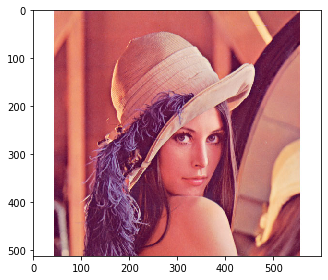

In [ ]:
pic = imread('./lenna.jpg')
imshow(pic)

Напишем код для функции `convolution` 

In [ ]:
# эта реализация без padding, а stride = 1
def convolution(img, filt):
    width, height = floor(filt.shape[0]/2), floor(filt.shape[1]/2)
    conv_img=img.copy()    
    for i in range(width, img.shape[0]-width):
        for j in range(height, img.shape[1]-height):
            conv_img[i,j] = np.clip((filt*img[(i-width):(i+width+1),(j-height):(j+height+1)]).sum(), 0, 255)
    return conv_img

Допишем также функцию применения свёртки для трёх каналов цветного изображения

In [ ]:
def convolution_rgb(image, filter):
    r = convolution(image[:,:,0], filter)
    g = convolution(image[:,:,1], filter)
    b = convolution(image[:,:,2], filter)
    conv_img = np.dstack((r, g, b))
    return conv_img

Протестируем разные ядра фильтров

In [ ]:
filt = np.array([[0, -1, 0],
                 [-1, 5, -1],
                 [0, -1, 0]])

In [ ]:
image2 = convolution_rgb (pic, filt)

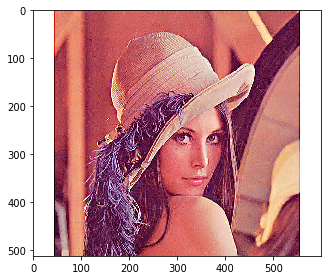

In [ ]:
imshow(image2)

Попробуем поменять фильтр и посмотреть, что будет.

In [ ]:
filt = 1/9 * np.array([[1, 1, 1],
                 [1, 1, 1],
                 [1, 1, 1]])

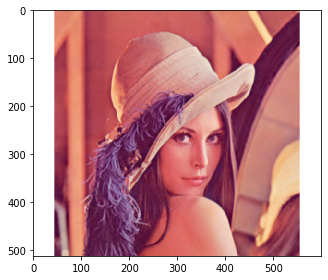

In [ ]:
image2 = convolution_rgb (pic, filt)
imshow(image2)

In [ ]:
# фильтр Собеля (горизонтальная составляющая)
filt = np.array([[1, 0, -1],
                 [2, 0, -2],
                 [1, 0, -1]])

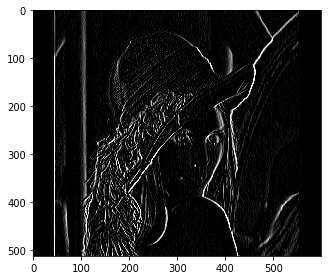

In [ ]:
# применяем только к красному каналу
image2 = convolution (pic[:,:,0], filt)
imshow(image2)

В библиотеке skimage есть модуль с разными фильтрами: https://scikit-image.org/docs/dev/api/skimage.filters.html

In [ ]:
from skimage import filters

In [ ]:
a = np.zeros((3, 3))
a[1, 1] = 1
a

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [ ]:
filters.gaussian(a, sigma=0.4)

array([[0.00163116, 0.03712502, 0.00163116],
       [0.03712502, 0.84496158, 0.03712502],
       [0.00163116, 0.03712502, 0.00163116]])

In [ ]:
filters.gaussian(a, sigma=1)

array([[0.05855018, 0.09653293, 0.05855018],
       [0.09653293, 0.15915589, 0.09653293],
       [0.05855018, 0.09653293, 0.05855018]])

In [ ]:
filtered_img = filters.gaussian(pic, sigma=1, multichannel=True)

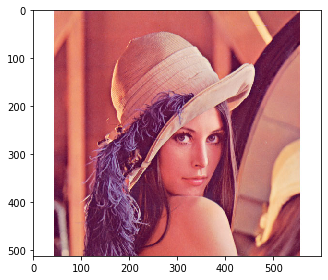

In [ ]:
imshow(pic)

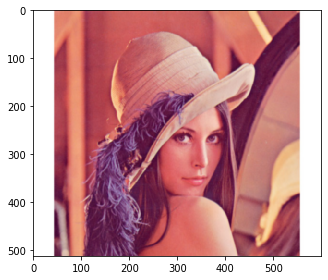

In [ ]:
imshow(filtered_img)

Фильтр unsharp mask 

$enhanced image = original + amount * (original - blurred)$

In [ ]:
filtered_img = filters.unsharp_mask(pic, radius=2, amount=0.5)

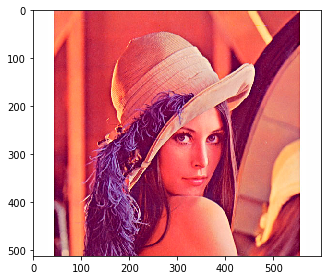

In [ ]:
imshow(filtered_img)

Фильтр Собеля (используется для выделения контуров, edge detection)

In [ ]:
filtered_img = filters.sobel (pic[:,:,0])

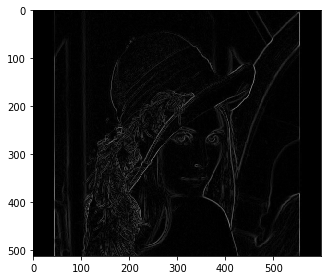

In [ ]:
imshow(filtered_img)

### Примечание

Во фреймворках и библиотеках глубокого обучения операция свёртки реализована намного более эффективно. Как минимум, саму функцию `convolution()` можно написать на NumPy в одну строчку (попробуйте сделать это), и это будет намного быстрее, чем версия, представленная выше (с циклами `for`) (она сделана исключительно для наглядности в учебных целях).

Также в [этой статье](https://arxiv.org/pdf/1709.03395.pdf) есть обзор эффективных способов представления операции свёртки, а в [этой](https://medium.com/nodeflux/demystifying-convolution-in-popular-deep-learning-framework-caffe-c74a58fe6bf8) более доступное объяснение.   
В cuDNN (библииотеке-ускорителе от NVIDIA) ускорение свёртки достигается за счёт алгоритма im2col.

### Pooling

Pooling (пулинг) - операция, нужная для уменьшения размерности по ширине и по высоте. Можно брать разные операции в качестве пулинга, например, минимум из элементов, максимум, среднее, медиану, сумму. 

Обычно используется max- и avg-pooling.

Пример применения max-pooling'а:

<img src="https://i.stack.imgur.com/W9a9n.jpg">

Примеры применения max и avg pooling'ов:


<img src="https://www.researchgate.net/profile/Zenghui_Wang2/publication/317496930/figure/fig1/AS:551445004066816@1508486142257/Average-versus-max-pooling.png">

Если на вход подаётся изображение с несколькими каналами, то пулинг берётся поканально, то есть если это цветная картинка HxWxC, и мы применяем к ней pooling 2x2 со страйдом 2, то получим на выходе (H // 2) x (W // 2) x C